<a href="https://colab.research.google.com/github/jsokolowska/text-classification/blob/practical-excercise/practicalExcercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup
====

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import nltk
import numpy as np
nltk.download('punkt')
%matplotlib inline


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
data_paths = [f'drive/MyDrive/Data/refsa-sample-data/{x}/use_as_train_{x}.csv' for x in ["ERIS", "Isoflavones", "Bacillus"]]
validation_paths =  [f'drive/MyDrive/Data/refsa-sample-data/{x}/use_as_validation_{x}.csv' for x in ["ERIS", "Isoflavones", "Bacillus"]]
preprocessed_dir = 'drive/MyDrive/Data/refsa-sample-data/cleaned/'

In [4]:
df = pd.read_csv(data_paths[0], index_col=0)
df_test = pd.read_csv(validation_paths[0], index_col=0)
print("Class -1")
print("Train data:", len(df[df['Indicator']==-1]), "out of", len(df))
print("Test data:", len(df_test[df_test['Indicator']==-1]),"out of" , len(df_test))

print("Class 1")
print("Train data:",len(df[df['Indicator']==1]), "out of", len(df))
print("Test data:",len(df_test[df_test['Indicator']==1]),"out of" , len(df_test))

Class -1
Train data: 437 out of 527
Test data: 112 out of 132
Class 1
Train data: 90 out of 527
Test data: 20 out of 132


In [5]:
#loading preprocessed data to make each section indepenent
def load_preprocessed(which):
  datasets = ["cleaned", "bow", "glove", "tfidf"]
  if which not in datasets:
    print("Expected one of the values: ", datasets)
    return
  df_train = pd.read_csv(preprocessed_dir + which + "_train_ERIS.csv", index_col=0)
  df_test = pd.read_csv(preprocessed_dir + which + "_test_ERIS.csv", index_col=0)
  X_train = df_train.drop("Indicator", axis=1)
  y_train = df_train["Indicator"]

  X_test = df_test.drop("Indicator", axis=1)
  y_test = df_test["Indicator"]
  return X_train, X_test, y_train, y_test

Initial data exploration
====



In [6]:
df = pd.read_csv(data_paths[0], index_col=0)
df_test = pd.read_csv(validation_paths[0], index_col=0)

print(df.shape, df_test.shape)
df.head()

(527, 5) (132, 5)


,X...Author,Title,Abstract,Journal,Indicator
377,"O. Wessel, C. M. Olsen, E. Rimstad and M. K. D...",Piscine orthoreovirus (PRV) replicates in Atla...,Piscine orthoreovirus (PRV) is a reovirus that...,Vet Res,-1
172,"M. C. Hikke, C. Geertsema, V. Wu, S. W. Metz, ...",Alphavirus capsid proteins self-assemble into ...,The mosquito-borne chikungunya virus (CHIKV) c...,Biotechnol J,-1
248,"J. Nacher-Mestre, R. Serrano, E. Beltran, J. P...",Occurrence and potential transfer of mycotoxin...,Plant ingredients and processed animal protein...,Chemosphere,1
525,"B. D. Johnson, S. L. Gilbert, B. Khan, D. L. C...","Cellular responses of eastern oysters, Crassos...",Because of the continued development and produ...,Mar Environ Res,1
614,"L. Zi-qi, M. Qian, S. Feng-qing, W. Ying-wen, ...",Research progress of chitosan and its derivati...,"Recently, the problem of heavy metal pollution...",Food & Machinery,-1


In [7]:
#check for null values
df.isnull().sum()

X...Author    0
Title         0
Abstract      0
Journal       1
Indicator     0
dtype: int64

In [8]:
X = df[["Title", "Abstract"]].copy()
y_train = df["Indicator"]

X_test = df_test[["Title", "Abstract"]]
y_test = df_test["Indicator"]

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

#preprocess train data
vectorizerAb = CountVectorizer()
vectorizerTit = CountVectorizer()

preprocessedAbstract = vectorizerAb.fit_transform(X["Abstract"].values)
abstracts = pd.DataFrame(data=preprocessedAbstract.toarray(), index=X.index, columns = vectorizerAb.get_feature_names())

preprocessedTitle = vectorizerTit.fit_transform(X["Title"].values)
titles = pd.DataFrame(data=preprocessedTitle.toarray(), index=X.index, columns = vectorizerTit.get_feature_names())

x_train = pd.concat([abstracts, titles], axis=1)

preprocessedAbstract = vectorizerAb.transform(X_test["Abstract"].values)
abstracts = pd.DataFrame(data=preprocessedAbstract.toarray(), index=X_test.index, columns = vectorizerAb.get_feature_names())

preprocessedTitle = vectorizerTit.transform(X_test["Title"].values)
titles = pd.DataFrame(data=preprocessedTitle.toarray(), index=X_test.index, columns = vectorizerTit.get_feature_names())

x_test= pd.concat([abstracts, titles], axis=1)
print(x_test.shape, x_train.shape)

(132, 13227) (527, 13227)


In [10]:
# Both train and test datasets are very small so it would be a good idea to first
# check if they come from the same data distribution using Adversial Validation
from scipy import sparse
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

def adversial_validation(train_df, test_df, n_splits=5):
  train_df["__dist"]=np.zeros((train_df.shape[0],))
  test_df["__dist"]=np.ones((test_df.shape[0],))

  merged = pd.concat([train_df, test_df], axis=0)
  features = merged.drop("__dist", axis=1)
  dists = merged["__dist"]

  auc_log = []
  auc_rf = []
  kfold = StratifiedKFold(n_splits=n_splits, shuffle=True)

  for train_idx, test_idx in kfold.split(features, dists):
    x_train, y_train = features.take(train_idx), dists.take(train_idx)
    x_test, y_test = features.take(test_idx), dists.take(test_idx)

    #train sgd
    log = LogisticRegression()
    log.fit(x_train, y_train)
    test_prob = log.predict_proba(x_test)[:,1]
    auc_log.append(roc_auc_score(y_test, test_prob))

    #train random forests
    rf = RandomForestClassifier(n_estimators=100, n_jobs = -1)
    rf.fit(x_train, y_train)
    test_prob = rf.predict_proba(x_test)[:,1]
    auc_rf.append(roc_auc_score(y_test, test_prob))

  print(f'RandomForest: {np.mean(auc_rf)}')
  print(f'Logistic Regression: {np.mean(auc_log)}')

adversial_validation(x_train.copy(), x_test.copy())

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


RandomForest: 0.4719865843450749
Logistic Regression: 0.5392929967772735


AUC score abround 50 % siginifies that test data is drawn from the same distribution as train data. That's good news - one worry less

Cleaning the data
===


In [11]:
df = pd.read_csv(data_paths[0], index_col=0)
df_test = pd.read_csv(validation_paths[0], index_col=0)

X = df.drop("Indicator", axis=1)
y_train = df["Indicator"]

X_test = df_test.drop("Indicator", axis=1)
y_test = df_test["Indicator"]
print(X.shape, y_train.shape, X_test.shape, y_test.shape)
X.head()

(527, 4) (527,) (132, 4) (132,)


,X...Author,Title,Abstract,Journal
377,"O. Wessel, C. M. Olsen, E. Rimstad and M. K. D...",Piscine orthoreovirus (PRV) replicates in Atla...,Piscine orthoreovirus (PRV) is a reovirus that...,Vet Res
172,"M. C. Hikke, C. Geertsema, V. Wu, S. W. Metz, ...",Alphavirus capsid proteins self-assemble into ...,The mosquito-borne chikungunya virus (CHIKV) c...,Biotechnol J
248,"J. Nacher-Mestre, R. Serrano, E. Beltran, J. P...",Occurrence and potential transfer of mycotoxin...,Plant ingredients and processed animal protein...,Chemosphere
525,"B. D. Johnson, S. L. Gilbert, B. Khan, D. L. C...","Cellular responses of eastern oysters, Crassos...",Because of the continued development and produ...,Mar Environ Res
614,"L. Zi-qi, M. Qian, S. Feng-qing, W. Ying-wen, ...",Research progress of chitosan and its derivati...,"Recently, the problem of heavy metal pollution...",Food & Machinery


In [12]:
for abs in df["Abstract"][:1]:
    print(abs + "\n")

Piscine orthoreovirus (PRV) is a reovirus that has predominantly been detected in Atlantic salmon (Salmo salar L.). PRV is associated with heart and skeletal muscle inflammation (HSMI) in farmed Atlantic salmon, and recently erythrocytes were identified as major target cells. The study of PRV replication and pathogenesis of the infection has been impeded by the inability to propagate PRV in vitro. In this study we developed an ex vivo cultivation system for PRV in Atlantic salmon erythrocytes. PRV was successfully passaged to naive erythrocytes using lysates of blood cells from infected salmon. During cultivation a significant increase in viral load was observed by RT-qPCR and flow cytometry, which coincided with the formation of cytoplasmic inclusions. The inclusions resembled viral factories and contained both PRV protein and dsRNA. In addition, the erythrocytes generated an antiviral immune gene activation after PRV infection, with significant up-regulation of IFN-alpha, RIG-I, Mx a

Things to consider when cleaning the data:
- abreviations
- numeric values and citation numbers
- hyphenated words like *mosquito-borne*

There is probably no need to remove contractions due to scientific nature of the data. 


In [13]:
#tokenize and lowercase
from nltk.tokenize import word_tokenize

def tokenize_and_lower(s):
    return [x.lower() for x in word_tokenize(s)]


X["tokenized_abstract"] = X["Abstract"].apply(tokenize_and_lower)
X_test["tokenized_abstract"] = X_test["Abstract"].apply(tokenize_and_lower)

X.head()

,X...Author,Title,Abstract,Journal,tokenized_abstract
377,"O. Wessel, C. M. Olsen, E. Rimstad and M. K. D...",Piscine orthoreovirus (PRV) replicates in Atla...,Piscine orthoreovirus (PRV) is a reovirus that...,Vet Res,"[piscine, orthoreovirus, (, prv, ), is, a, reo..."
172,"M. C. Hikke, C. Geertsema, V. Wu, S. W. Metz, ...",Alphavirus capsid proteins self-assemble into ...,The mosquito-borne chikungunya virus (CHIKV) c...,Biotechnol J,"[the, mosquito-borne, chikungunya, virus, (, c..."
248,"J. Nacher-Mestre, R. Serrano, E. Beltran, J. P...",Occurrence and potential transfer of mycotoxin...,Plant ingredients and processed animal protein...,Chemosphere,"[plant, ingredients, and, processed, animal, p..."
525,"B. D. Johnson, S. L. Gilbert, B. Khan, D. L. C...","Cellular responses of eastern oysters, Crassos...",Because of the continued development and produ...,Mar Environ Res,"[because, of, the, continued, development, and..."
614,"L. Zi-qi, M. Qian, S. Feng-qing, W. Ying-wen, ...",Research progress of chitosan and its derivati...,"Recently, the problem of heavy metal pollution...",Food & Machinery,"[recently, ,, the, problem, of, heavy, metal, ..."


In [14]:
#remove punctuation and stopwords
import string
from nltk.corpus import stopwords
nltk.download('stopwords')

chars_for_removal = set(list(string.punctuation) + stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
def filter_words(string_list):
    return [word for word in string_list if word not in chars_for_removal]

X["filtered_abstract"] = X["tokenized_abstract"].apply(filter_words)
X_test["filtered_abstract"] = X_test["tokenized_abstract"].apply(filter_words)

In [16]:
#adding pos tags for lemmatization with wordnet
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

X["pos_abstract"] = X["filtered_abstract"].apply(nltk.tag.pos_tag)
X_test["pos_abstract"] = X_test["filtered_abstract"].apply(nltk.tag.pos_tag)

def map_to_wordnet_pos(tuple_list):
    return [(word, get_wnet_tag(tag)) for (word, tag) in tuple_list]
 
def get_wnet_tag(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    if tag.startswith('V'):
        return wordnet.VERB
    if tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
X_test["wntag_abstract"] = X_test["pos_abstract"].apply(map_to_wordnet_pos)  
X["wntag_abstract"] = X["pos_abstract"].apply(map_to_wordnet_pos)   


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [17]:
#lemmatize with wordnet
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer()

def lemmatize(tuple_list):
    return [lemmatizer.lemmatize(word, tag) for (word, tag) in tuple_list]

X["lem_abstract"] = X["wntag_abstract"].apply(lemmatize)

X_test["lem_abstract"] = X_test["wntag_abstract"].apply(lemmatize)

cleaned_text = pd.DataFrame(data=X["lem_abstract"], index = X.index)
cleaned_text = cleaned_text.rename(columns={"lem_abstract": "abstract"})

cleaned_text_test = pd.DataFrame(data=X_test["lem_abstract"], index = X_test.index)
cleaned_text_test = cleaned_text_test.rename(columns={"lem_abstract": "abstract"})


In [18]:
# connect lists back into strings
def list_to_string (str_list):
  return " ".join(str_list)
cleaned_text["abs_str"] = cleaned_text["abstract"].apply(list_to_string)

cleaned_text_test["abs_str"] = cleaned_text_test["abstract"].apply(list_to_string)

cleaned_text = cleaned_text.drop(labels = ["abstract"], axis=1)
cleaned_text_test = cleaned_text_test.drop(labels = ["abstract"], axis=1)

print(cleaned_text.head())

                                               abs_str
377  piscine orthoreovirus prv reovirus predominant...
172  mosquito-borne chikungunya virus chikv cause a...
248  plant ingredient process animal protein pap su...
525  continued development production variety nanom...
614  recently problem heavy metal pollution attract...


In [19]:
clean_train = pd.concat([cleaned_text, y_train], axis=1)
clean_train.to_csv(preprocessed_dir + "cleaned_train_ERIS.csv")
clean_test =pd.concat([cleaned_text_test, y_test], axis=1)
clean_test.to_csv(preprocessed_dir +"cleaned_test_ERIS.csv")
print(clean_train.shape, clean_test.shape)

(527, 2) (132, 2)


Exploratory Data Analysis
===

In [20]:
X_train, X_test, y_train, y_test = load_preprocessed("cleaned")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) #sanity check
X_train.head()

(527, 1) (132, 1) (527,) (132,)


,abs_str
377,piscine orthoreovirus prv reovirus predominant...
172,mosquito-borne chikungunya virus chikv cause a...
248,plant ingredient process animal protein pap su...
525,continued development production variety nanom...
614,recently problem heavy metal pollution attract...


In [21]:
X_rel = X_train[y_train==1]
X_irrel = X_train[y_train==-1]

abs_words_rel = []
for abs_word in X_rel["abs_str"]:
  abs_words_rel += abs_word.split(" ")

abs_words_irrel = []
for abs_word in X_irrel["abs_str"]:
  abs_words_irrel += abs_word.split(" ")


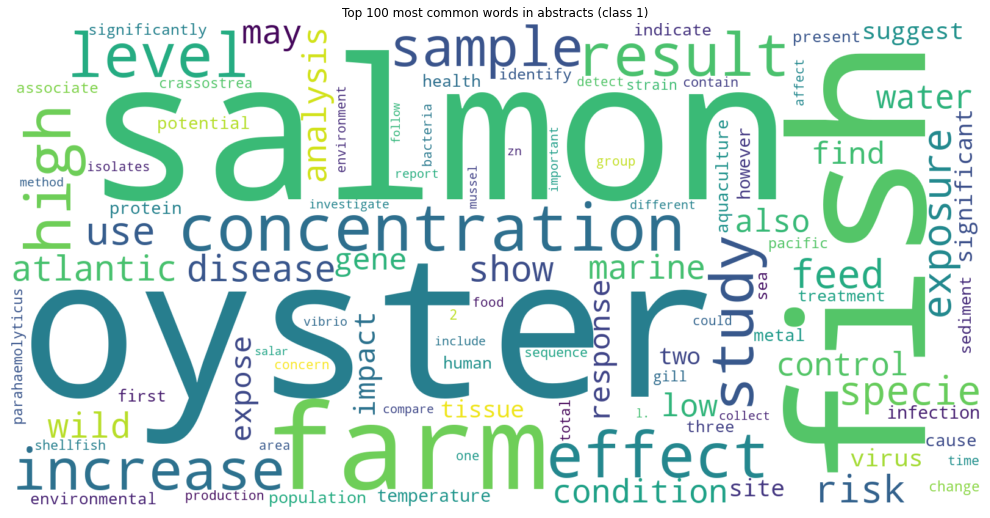

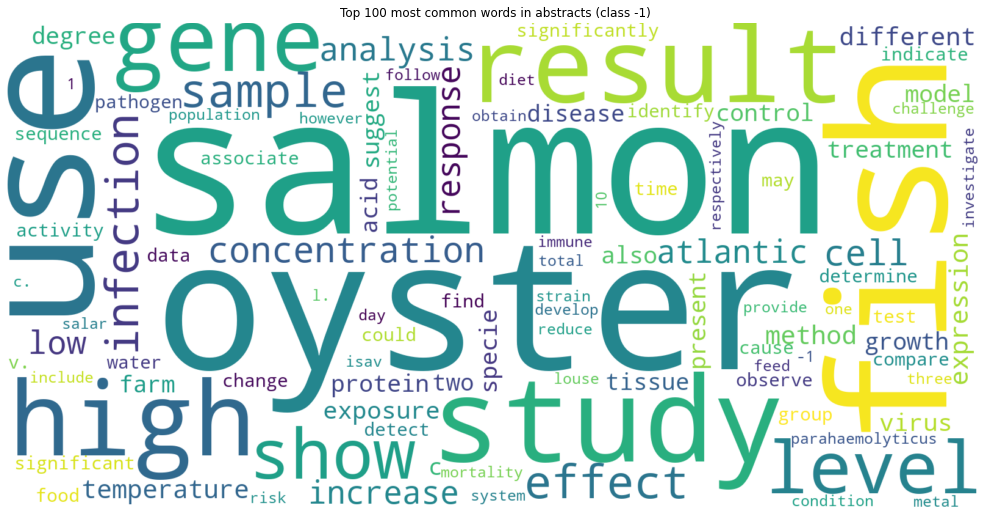

In [22]:
from nltk.probability import FreqDist
from wordcloud import WordCloud
def to_dict(tuple_list):
  result = dict()
  for key, value in tuple_list:
    result[key]=value
  return result


most_rel = to_dict(FreqDist(abs_words_rel).most_common(100))
cloud_a = WordCloud(width=1600, height= 800, background_color='white').fit_words(most_rel)
fig = plt.figure(figsize=(20,7), facecolor='white')
plt.imshow(cloud_a, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 most common words in abstracts (class 1)')
plt.tight_layout(pad=0)
plt.show()
print("\n\n")
most_irrel = to_dict(FreqDist(abs_words_irrel).most_common(100))
cloud_a = WordCloud(width=1600, height= 800, background_color='white').fit_words(most_irrel)
fig = plt.figure(figsize=(20,7), facecolor='white')
plt.imshow(cloud_a, interpolation='bilinear')
plt.axis('off')
plt.title('Top 100 most common words in abstracts (class -1)')
plt.tight_layout(pad=0)
plt.show()

A first glance look at most popular words in both classes does not seem to indicate much difference between them - they both talk about oysters and fish, research and its results

In [23]:
#dimensionality reduction for visualisation purposes
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, n_iter=10)
reduced_train = svd.fit_transform(x_train)

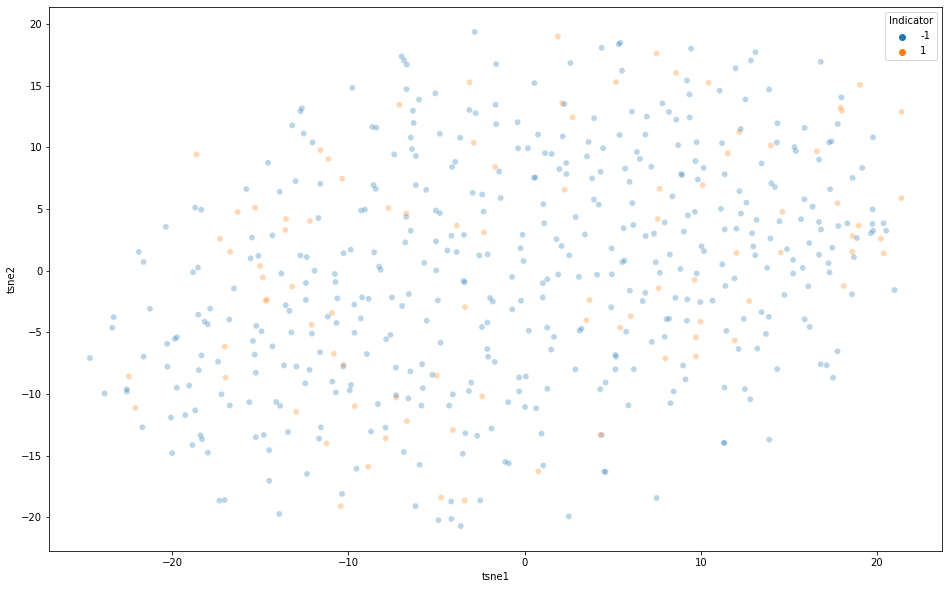

In [24]:
from sklearn.manifold import TSNE
X_embedded = pd.DataFrame(TSNE(n_components=2).fit_transform(reduced_train), index = x_train.index, columns=["tsne1", "tsne2"])

plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne1", y="tsne2", hue = y_train, data = X_embedded, legend="full", alpha=0.3, palette = sns.color_palette(n_colors=2) )


Both of the classes seem very mixed with bow encoding so it will most likely be necessary to explore different embedding options

Classification
===


In [25]:
X_train, X_test, y_train, y_test = load_preprocessed("cleaned")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(527, 1) (132, 1) (527,) (132,)


In [26]:
#baseline classifier - always return majority class
class BaselineClassifier:
    def __init__(self):
        self.majority_class = np.NaN
        
    def fit(self, x, y):
        self.majority_class = y.value_counts()[:1].index.to_list()[0]
        return
    def predict(self, x):
        return pd.Series(np.ones((x.shape[0],)) * self.majority_class, index = x.index)
    
    def score(self, x, y):
        p = self.predict(x)
        comp = y==p
        return len(comp[comp==True])/len(comp)
        
        
baseline = BaselineClassifier()
baseline.fit(X_test,y_train)
score = baseline.score(X_test, y_test)
print(f'Baseline classifier\'s accuracy (always returns majority class): {score}')

Baseline classifier's accuracy (always returns majority class): 0.8484848484848485


**Baseline classifier** achieves expected accuracy -  84,84% which corresponds to how many of training examples are of majority class. 

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

#preprocess train data
vectorizerAb = CountVectorizer()
vectorizerTit = CountVectorizer()

preprocessedAbstract = vectorizerAb.fit_transform(X_train["abs_str"].values)
abstracts = pd.DataFrame(data=preprocessedAbstract.toarray(), index=cleaned_text.index, columns = vectorizerAb.get_feature_names())

x_train = abstracts
print(x_train.shape)
print(x_train.head())

(527, 9455)
     00  000  0000  0001  0003  ...  zrp  zt6  zymogen  zymosan  ác
377   0    0     0     0     0  ...    0    0        0        0   0
172   0    0     0     0     0  ...    0    0        0        0   0
248   0    0     0     0     0  ...    0    0        0        0   0
525   0    0     0     0     0  ...    0    0        0        0   0
614   0    0     0     0     0  ...    0    0        0        0   0

[5 rows x 9455 columns]


In [28]:
#preprocess test data
abstracts_test = vectorizerAb.transform(cleaned_text_test["abs_str"].values)

x_test = pd.DataFrame(data=abstracts_test.toarray(), index = cleaned_text_test.index, columns = vectorizerAb.get_feature_names())

print(x_test.shape)
x_test.head()

(132, 9455)


,00,000,0000,0001,0003,0006,000smolts,001,002,0025,0026,003,004,005,006,007,01,0135,0138,014,018,02,022,023,024,026,0296,03,035,0366,04,0421,045,0467,047,04pmol,05,050mugl,05mugl,06,...,yarrowia,yarrowiali,year,yearling,yeast,yellow,yersinia,yersiniosis,yessoensis,yet,yield,yielded,yl,yolk,york,young,yr,zealand,zearalenone,zebrafish,zeitgebers,zero,zglp1,zhejiang,zhelin,zinc,zn,zncl2,znt1,zone,zool,zoonotic,zooplankters,zooplankton,zoosporulate,zrp,zt6,zymogen,zymosan,ác
374,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
304,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
247,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
125,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
# save vectorized test and train data
test_bow = pd.concat([x_test, y_test], axis=1)
train_bow = pd.concat([x_train, y_train], axis=1)
print(test_bow.shape, train_bow.shape)
test_bow.to_csv(preprocessed_dir + "bow_test_ERIS.csv")
train_bow.to_csv(preprocessed_dir + "bow_train_ERIS.csv")

(132, 9456) (527, 9456)


In [30]:
from sklearn.linear_model import LogisticRegression
scores = {}
y = y_train
logistic = LogisticRegression()
logistic.fit(x_train, y)
test_score_logistic = logistic.score(x_test, y_test)
train_score_logistic = logistic.score(x_train, y_train)
print(f'Accuracy for Logistic Regression Classifier with CountVectorization\n test: {test_score_logistic}\t\t train: {train_score_logistic}')

Accuracy for Logistic Regression Classifier with CountVectorization
 test: 0.7878787878787878		 train: 1.0


In [31]:
from sklearn.svm import LinearSVC
scores = {}
y = y_train
linearSVC = LinearSVC()
linearSVC.fit(x_train, y)
test_score_linearSVC = linearSVC.score(x_test, y_test)
train_score_linearSVC = linearSVC.score(x_train, y_train)
print(f'Accuracy for Linear SVC with CountVectorization\n test: {test_score_linearSVC}\t train: {train_score_linearSVC}')

Accuracy for Linear SVC with CountVectorization
 test: 0.7803030303030303	 train: 1.0


Improving classification
====



Utilities
---

In [32]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, recall_score
def calculate_metrics (X_test, y_test, model, verbose=False, confusion = False):
  y_pred = model.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  re = recall_score(y_test, y_pred)
  if confusion:
    cm = confusion_matrix(y_test, y_pred)

    plt.title('Confusion Matrix')
    sns.set(font_scale=1.0) #for label size
    sns.heatmap(cm, annot = True, fmt = 'd', xticklabels = ['-1', '1'], yticklabels = ['-1', '1'], annot_kws={"size": 14}, cmap = 'Blues')

    plt.xlabel('Truth')
    plt.ylabel('Prediction')
    plt.show()
  if verbose:
    print(f'Accuracy: {acc}\tF1 score: {f1}\tRecall: {re}')
  return (acc, f1, re)

In [33]:
from sklearn.metrics import roc_auc_score, average_precision_score, plot_precision_recall_curve, plot_roc_curve
def calculate_and_plot(x_test, y_test, model, plot=True):
    y_prob = model.predict_proba(x_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_prob)
    avg_prec = average_precision_score(y_test, y_prob)

    if plot:
      plot_precision_recall_curve(model,x_test, y_test)
      plt.show()
      print("\n")
      plot_roc_curve(model, x_test, y_test)
      plt.show()
  
    return roc_auc, avg_prec
   


Bag of Words model
---

In [34]:
x_test, x_train, y_test, y_train = load_preprocessed("bow")
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape) #sanity check

(132, 9455) (527, 9455) (132,) (527,)


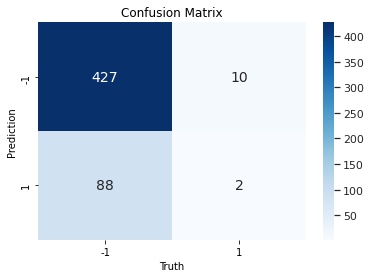

Accuracy: 0.8140417457305503	F1 score: 0.0392156862745098	Recall: 0.022222222222222223


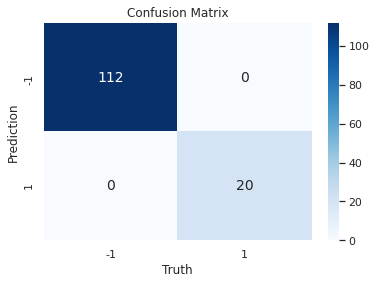

Accuracy: 1.0	F1 score: 1.0	Recall: 1.0


In [35]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
logistic.fit(x_train, y_train)
#print("Scores for LogisticRegression with BOW model - test data")
log_bow = calculate_metrics(x_test, y_test, logistic, True, True)
#print("Scores for LogisticRegression with BOW model - train data")
log_bow = calculate_metrics(x_train, y_train, logistic, True, True)

TF-IDF vectorization
----


In [36]:
X_train, X_test, y_train, y_test = load_preprocessed("cleaned")
X_train.head()

,abs_str
377,piscine orthoreovirus prv reovirus predominant...
172,mosquito-borne chikungunya virus chikv cause a...
248,plant ingredient process animal protein pap su...
525,continued development production variety nanom...
614,recently problem heavy metal pollution attract...


In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
document_list = X_train["abs_str"].tolist()
test_docs = X_test["abs_str"].tolist()


tfidf = TfidfVectorizer()
x_train_tfidf = pd.DataFrame(tfidf.fit_transform(document_list).toarray(), 
                             index = X_train.index, columns = tfidf.get_feature_names())
x_test_tfidf =  pd.DataFrame(tfidf.transform(test_docs).toarray(), 
                             index = X_test.index, columns = tfidf.get_feature_names())
print(x_train_tfidf.shape, x_test_tfidf.shape)

(527, 9455) (132, 9455)


In [38]:
df_train = pd.concat([x_train_tfidf, y_train], axis=1)
df_train.to_csv(preprocessed_dir + "tfidf_train_ERIS.csv")

df_test = pd.concat([x_test_tfidf, y_test], axis=1)
df_test.to_csv(preprocessed_dir + "tfidf_test_ERIS.csv")

Scores for LogisticRegression with tfidf model


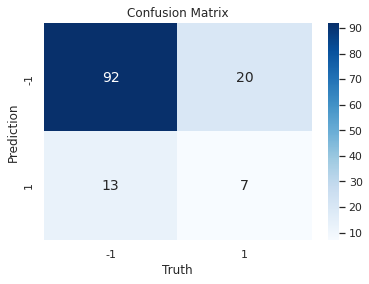

Accuracy: 0.75	F1 score: 0.29787234042553196	Recall: 0.35


In [39]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(class_weight='balanced')
logistic.fit(x_train_tfidf, y_train)
print("Scores for LogisticRegression with tfidf model")
log_tfidf = calculate_metrics(x_test_tfidf, y_test, logistic, True, True)

Word embeddings
----

In [40]:
X_train, X_test, y_train, y_test = load_preprocessed("cleaned")
X_train.head()

,abs_str
377,piscine orthoreovirus prv reovirus predominant...
172,mosquito-borne chikungunya virus chikv cause a...
248,plant ingredient process animal protein pap su...
525,continued development production variety nanom...
614,recently problem heavy metal pollution attract...


In [41]:
import io

def load_glove():
  glove_dir = "drive/MyDrive/Data/embeddings/glove.6B/glove.6B.100d.txt"
  embeddings_idx = {}
  with io.open(glove_dir) as glove_f:
    for line in glove_f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:],dtype='float32')
      embeddings_idx[word]=vector
  return embeddings_idx

glove_dict = load_glove()


In [42]:
def avg_glove(word_list):
  vectors =[]
  for word in word_list:
    if word in glove_dict.keys():
      vectors.append(glove_dict[word])
  return np.array(vectors).mean(axis=0)

In [43]:
embed_list_train = [avg_glove(row["abs_str"]) for idx, row in X_train.iterrows()]
embeddings_train = pd.DataFrame(embed_list_train, index = X_train.index)

embed_list_test = [avg_glove(row["abs_str"]) for idx, row in X_test.iterrows()]
embeddings_test = pd.DataFrame(embed_list_test, index = X_test.index)

In [44]:
glove_train = pd.concat([embeddings_train, y_train], axis=1)
glove_test = pd.concat([embeddings_test, y_test], axis=1)

glove_test.to_csv(preprocessed_dir + "glove_test_ERIS.csv")
glove_train.to_csv(preprocessed_dir + "glove_train_ERIS.csv")


Comparison of different classifiers
----


To compare - 3 vectorization methods and 4 classifiers (RandomForest, LinearSVC, LogisticRegression, kNN)

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve
from sklearn.metrics import average_precision_score, roc_auc_score

In [46]:
classifiers = [LogisticRegression(class_weight='balanced'), RandomForestClassifier(class_weight='balanced'), KNeighborsClassifier()]
vec_method = ["bow", "tfidf", "glove"]
vec_to_full = {"bow": "Bag of Words", "tfidf": "TF-IDF", "glove": "Averaged GloVe"}
class_types = ["log", "rf","knn"]
datasets = {}
for m in vec_method:
  x_train, x_test, y_train, y_test = load_preprocessed(m)
  datasets[m] = (x_train, x_test)

#prepare scores dict
auc_scores = {}
avg_pr_scores = {}
for m in vec_method:
  auc_scores[m]={}
  avg_pr_scores[m]={}
  for c in class_types:
    auc_scores[m][c]=-1
    avg_pr_scores[m][c]=-1


Comparison of classification methods for Bag of Words representation of documents


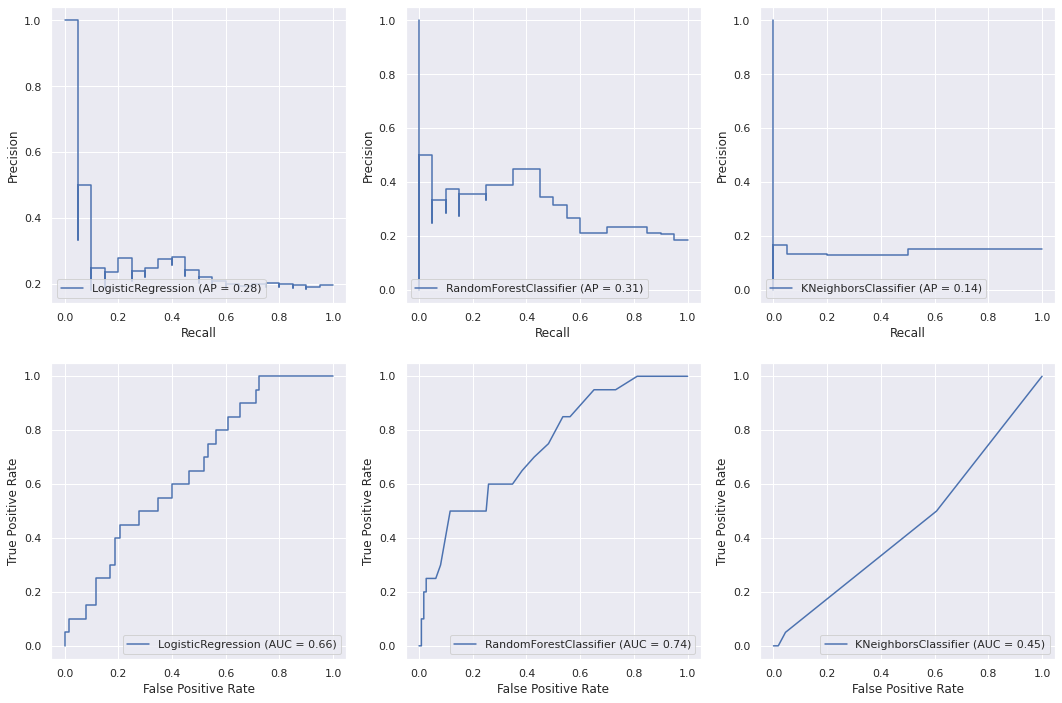




Comparison of classification methods for TF-IDF representation of documents


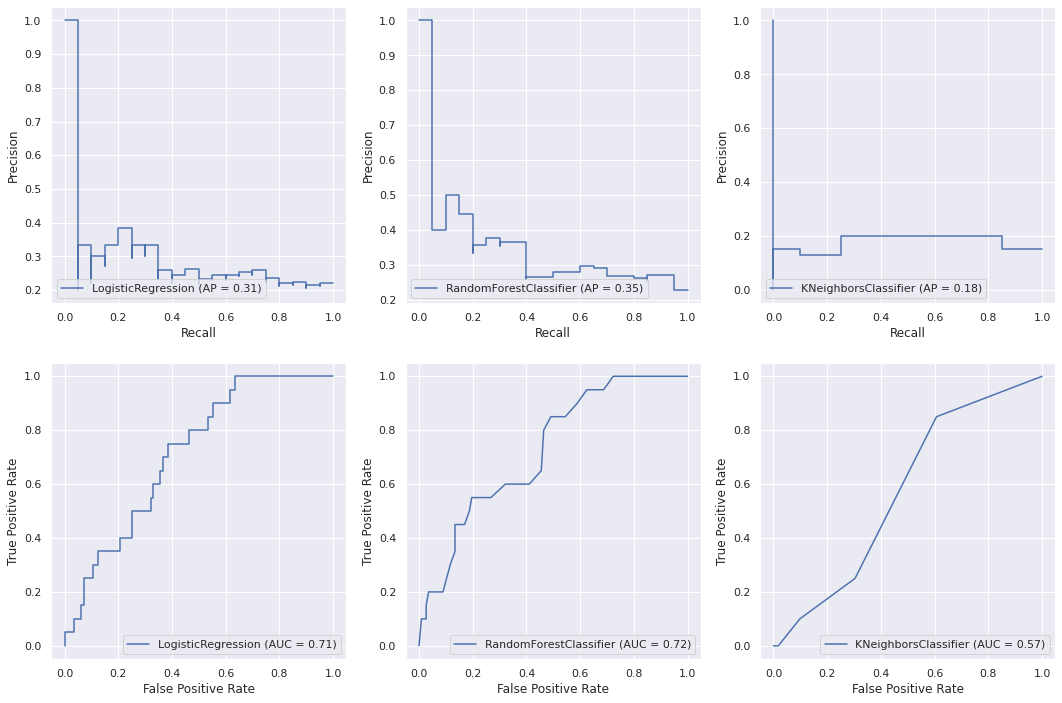




Comparison of classification methods for Averaged GloVe representation of documents


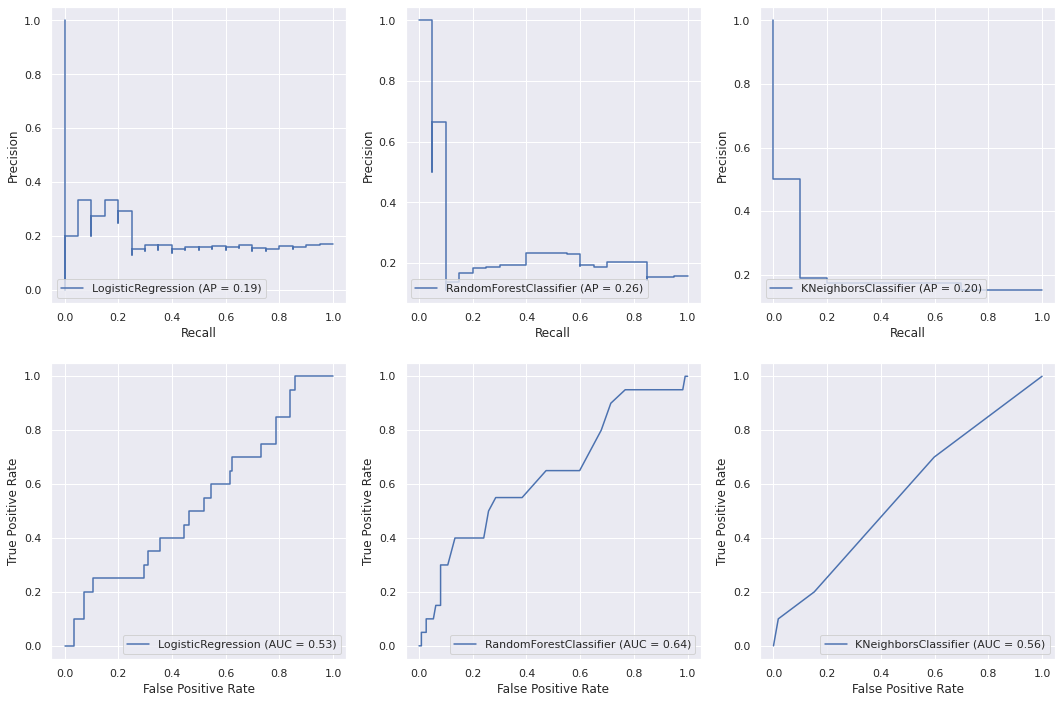

In [47]:
#class labels in variables y_train, y_test
v_num = len(vec_method)
c_num = len(classifiers)
#fig, axs = plt.subplot(nrows=v_num, ncols=c_num)
for vec in vec_method:
  print(f"Comparison of classification methods for {vec_to_full[vec]} representation of documents")
  x_train = datasets[vec][0]
  x_test = datasets[vec][1]
  
  fig, axs = plt.subplots(2,len(classifiers),figsize=(18,12))
  axes = [axs[0][a] for a in range(len(classifiers))]
  for i in range(len(classifiers)):
    clf = classifiers[i]
    clf.fit(x_train, y_train)
    plot_precision_recall_curve(clf,x_test, y_test, ax=axes[i])

  axes = [axs[1][a] for a in range(len(classifiers))]
  for i in range(len(classifiers)):
    clf = classifiers[i]
    clf.fit(x_train, y_train)
    plot_roc_curve(clf, x_test, y_test, ax=axes[i])
  plt.show()
  #calculate scores
  for i in range(len(classifiers)):
    class_t = class_types[i]
    clf = classifiers[i]
    y_score = clf.predict_proba(x_test)[:,1]
    auc_scores[vec][class_t]= roc_auc_score(y_test, y_score)
    avg_pr_scores[vec][class_t]=average_precision_score(y_test, y_score)

  print("\n\n")

In [48]:
from prettytable import PrettyTable
print("Results for unweighted classifiers and different document representations\n")
table = PrettyTable(["Classifier", "Bag of Words", "TF_IDF", "Averaged GloVe"])
table.add_row(["Logistic Regression"] +  [auc_scores[key]['log'] for key in auc_scores.keys()])
table.add_row(["Random Forest"] + [auc_scores[key]['rf'] for key in auc_scores.keys()])
table.add_row(["kNearestNeghbours"] + [auc_scores[key]['knn'] for key in auc_scores.keys()])

print(table.get_string(title="AUC ROC SCORES"), "\n")

table = PrettyTable(["Classifier", "Bag of Words", "TF_IDF", "Averaged GloVe"])
table.add_row(["Logistic Regression"] +  [auc_scores[key]['log'] for key in avg_pr_scores.keys()])
table.add_row(["Random Forest"] + [auc_scores[key]['rf'] for key in avg_pr_scores.keys()])
table.add_row(["kNearestNeghbours"] + [auc_scores[key]['knn'] for key in avg_pr_scores.keys()])
print(table.get_string(title="AVERAGE PRECISION SCORES"))

Results for unweighted classifiers and different document representations

+-------------------------------------------------------------------------------------+
|                                    AUC ROC SCORES                                   |
+---------------------+---------------------+--------------------+--------------------+
|      Classifier     |     Bag of Words    |       TF_IDF       |   Averaged GloVe   |
+---------------------+---------------------+--------------------+--------------------+
| Logistic Regression |  0.6558035714285715 | 0.7129464285714285 | 0.5330357142857143 |
|    Random Forest    |  0.7357142857142857 |       0.725        | 0.6379464285714285 |
|  kNearestNeghbours  | 0.45000000000000007 |     0.5703125      | 0.5633928571428571 |
+---------------------+---------------------+--------------------+--------------------+ 

+-------------------------------------------------------------------------------------+
|                               AVERAGE PRE

Weighted vs. unweighted classes -  RandomForest Classifier for different data representations


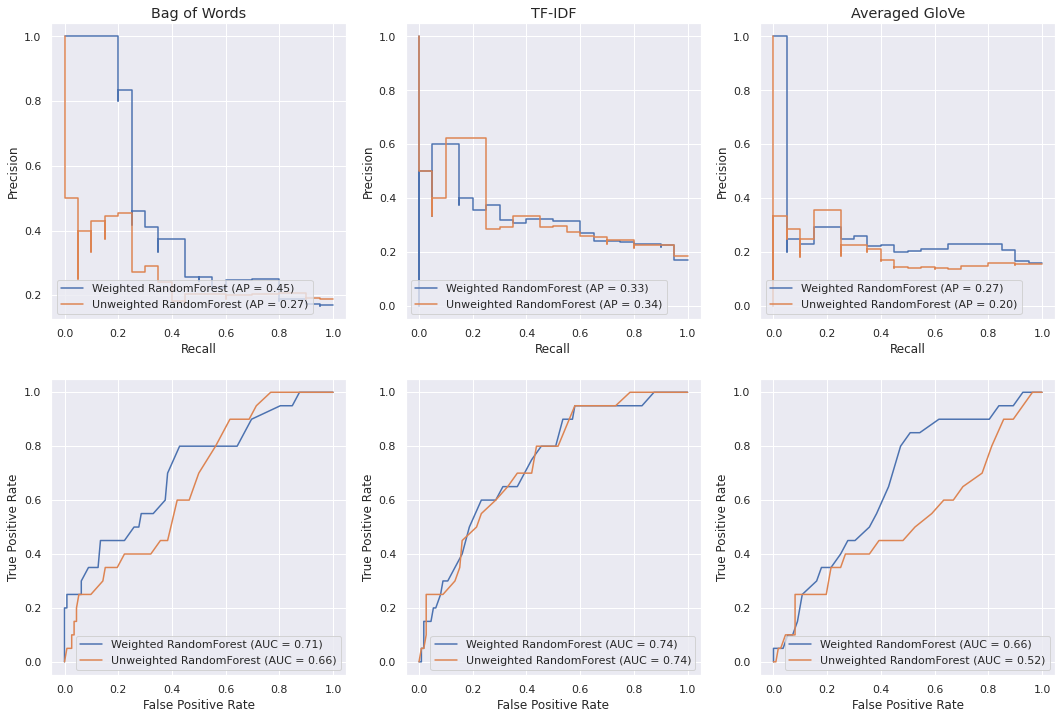

In [49]:
print("Weighted vs. unweighted classes -  RandomForest Classifier for different data representations")

rf_w = RandomForestClassifier(class_weight='balanced')
rf_u = RandomForestClassifier()
results = [[], [], [], []] #[avg_u], [avg_w], [roc_u], [roc_w]

fig, axes = plt.subplots(2,len(vec_method),figsize=(18,12))

for i in range(len(vec_method)):
  ax_prec = axes[0][i]
  ax_roc = axes[1][i]
  x_train = datasets[vec_method[i]][0]
  x_test = datasets[vec_method[i]][1]

  rf_w.fit(x_train, y_train)
  rf_u.fit(x_train, y_train)
  y_score_w = rf_w.predict_proba(x_test)[:,1]
  y_score_u = rf_u.predict_proba(x_test)[:,1]

  # calculate scores
  results[0].append(average_precision_score(y_test, y_score_u))
  results[1].append(average_precision_score(y_test, y_score_w))
  results[2].append(roc_auc_score(y_test, y_score_u))
  results[3].append(roc_auc_score(y_test, y_score_w))
  
  # plot curves
  plot_precision_recall_curve(rf_w, x_test, y_test, ax=ax_prec, name="Weighted RandomForest")
  plot_precision_recall_curve(rf_u, x_test, y_test, ax=ax_prec, name="Unweighted RandomForest")
  plot_roc_curve(rf_w, x_test, y_test, ax=ax_roc, name="Weighted RandomForest")
  plot_roc_curve(rf_u, x_test, y_test, ax=ax_roc, name="Unweighted RandomForest")

cols =["Bag of Words", "TF-IDF", "Averaged GloVe"]
for ax, col in zip(axes[0], cols):
  ax.annotate(col, xy=(0.5, 1), xytext=(0, 5),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
plt.show()

In [54]:
print("Weighted vs. unweighted classes -  RandomForest Classifier for different data representations\n")
table = PrettyTable(["Classifier ", "Bag of Words", "TF_IDF", "Averaged GloVe"])
table.add_row(["Unweighted Random Forest"] + results[2])
table.add_row(["Weighted Random Forest"] + results[3])
print(table.get_string(title="AUC ROC SCORES"), "\n")


table = PrettyTable(["Classifier", "Bag of Words", "TF_IDF", "Averaged GloVe"])
table.add_row(["Unweighted Random Forest"] + results[0])
table.add_row(["Weighted Random Forest"] + results[1])
print(table.get_string(title="AVERAGE PRECISION SCORES"), "\n")


Weighted vs. unweighted classes -  RandomForest Classifier for different data representations

+-----------------------------------------------------------------------------------------+
|                                      AUC ROC SCORES                                     |
+--------------------------+--------------------+--------------------+--------------------+
|       Classifier         |    Bag of Words    |       TF_IDF       |   Averaged GloVe   |
+--------------------------+--------------------+--------------------+--------------------+
| Unweighted Random Forest | 0.6584821428571428 | 0.7368303571428572 | 0.5223214285714286 |
|  Weighted Random Forest  | 0.7098214285714286 |     0.7359375      | 0.6604910714285714 |
+--------------------------+--------------------+--------------------+--------------------+ 

+-------------------------------------------------------------------------------------------+
|                                  AVERAGE PRECISION SCORES              